# JF image read
## Thomas Preston - European XFEL GmbH

In [7]:
%matplotlib notebook
import os
import numpy as np
import scipy
from scipy import optimize, ndimage

import matplotlib.pyplot as plt
from matplotlib import cm
from extra_data import *
import pandas as pd
import zipfile

## Prepare folder locations with experimental run and proposal number
## Change this cell!

In [8]:
# Create proposal directory
propno = "3213" #"p002353" 
home_dir = "/home/jchal/"
prop_dir = home_dir+"p"+propno

os.chdir(home_dir)

# Make the output directory - caution, this makes the directory here where you run this script.
if not os.path.exists("p"+propno):
    os.mkdir("p"+propno)
    os.chdir(home_dir+"p"+propno)
else:
    os.chdir(home_dir+"p"+propno)

print(os.getcwd())

/home/jchal/p3213


### Open run and create run folder

In [9]:
#Open run and create run folder
run_number = 31
run_dir = prop_dir + "/"+"Run"+str(run_number)

run = open_run(propno, run_number, "proc")
#run = open_run(propno, 302, "raw")
#run.info()

os.chdir(prop_dir)

if not os.path.exists("Run"+str(run_number)):
    os.mkdir("Run"+str(run_number))
    os.chdir(run_dir)    
else:
    os.chdir(run_dir)
   
print("Current directory: " + os.getcwd())
print("Run " + str(run_number) + " contains " + str(len(run.train_ids)) + " train_IDs.")
print("Proceed to next cells to start data extraction ...")

PermissionError: [Errno 13] Permission denied: '/gpfs/exfel/exp/HED/202221/p003213/proc/r0031'

In [6]:
run.instrument_sources
#run.info()

# of trains:    2065
Duration:       0:03:26.5
First train ID: 695489274
Last train ID:  695491338

0 detector modules ()

14 instrument sources (excluding detectors):
  - HED_IA1_JF500K3/DET/JNGFR03:daqOutput
  - HED_OPT_IPM/ADC/1:channel_0.output
  - HED_OPT_IPM/ADC/1:channel_1.output
  - HED_OPT_IPM/ADC/1:channel_2.output
  - HED_OPT_IPM/ADC/1:channel_3.output
  - HED_OPT_IPM/ADC/1:channel_4.output
  - HED_OPT_IPM/ADC/1:channel_5.output
  - HED_OPT_IPM/ADC/1:channel_6.output
  - HED_OPT_IPM/ADC/1:channel_7.output
  - HED_OPT_IPM/ADC/1:channel_8.output
  - HED_OPT_IPM/ADC/1:channel_9.output
  - HED_RR_SYS/MDL/KARABACON:output
  - HED_XTD6_XGM/XGM/DOOCS:output
  - SA2_XTD1_XGM/XGM/DOOCS:output

22 control sources:
  - HED_IA1_DETM/MOTOR/AXIS_10
  - HED_IA1_DETM/MOTOR/AXIS_2
  - HED_IA1_DETM/MOTOR/AXIS_3
  - HED_IA1_DETM/MOTOR/AXIS_4
  - HED_IA1_DETM/MOTOR/AXIS_5
  - HED_IA1_DETM/MOTOR/AXIS_7
  - HED_IA1_DETM/MOTOR/AXIS_8
  - HED_IA1_DETM/MOTOR/AXIS_9
  - HED_IA1_JF500K3/DET/CONTROL
  

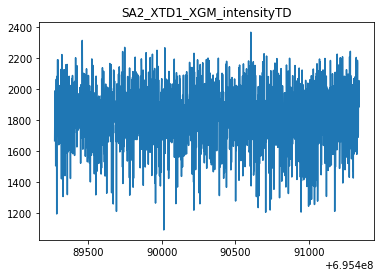

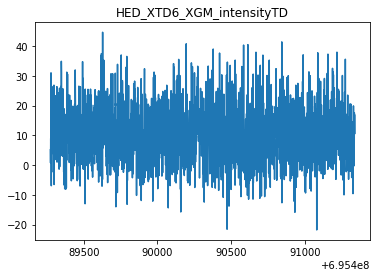

In [100]:
# Pulse energy data (XGM)
%matplotlib inline
SA2_XTD1_XGM_iTD = run['SA2_XTD1_XGM/XGM/DOOCS:output', 'data.intensityTD'].xarray().squeeze()
SA2_XTD1_XGM_tID = run['SA2_XTD1_XGM/XGM/DOOCS:output', 'data.trainId'].xarray().squeeze()

HED_XTD6_XGM_iTD = run['HED_XTD6_XGM/XGM/DOOCS:output', 'data.intensityTD'].xarray().squeeze()
HED_XTD6_XGM_tID = run['HED_XTD6_XGM/XGM/DOOCS:output', 'data.trainId'].xarray().squeeze()

SA2_XTD1_XGM = np.column_stack((SA2_XTD1_XGM_tID.data[:], SA2_XTD1_XGM_iTD.data[:,0]))
HED_XTD6_XGM = np.column_stack((HED_XTD6_XGM_tID.data[:], HED_XTD6_XGM_iTD.data[:,0]))

plt.plot(SA2_XTD1_XGM[:,0], SA2_XTD1_XGM[:,1])
plt.title("SA2_XTD1_XGM_intensityTD")
plt.show()

plt.plot(HED_XTD6_XGM[:,0], HED_XTD6_XGM[:,1])
plt.title("HED_XTD6_XGM_intensityTD")
plt.show()

# Save XGM data
os.chdir(prop_dir)
np.savetxt("Run" + str(run_number)+ "_SA2_XTD1_XGM.txt", SA2_XTD1_XGM, delimiter = ',', header = "SA2_XTD1_XGM_trainID, SA2_XTD1_XGM_intensityTD")
np.savetxt("Run" + str(run_number)+ "_HED_XTD6_XGM.txt", HED_XTD6_XGM, delimiter = ',', header = "HED_XTD6_XGM_trainID, HED_XTD6_XGM_intensityTD")

In [101]:
### Jungfrau data extraction and zipping

# JF3 = run['HED_IA1_JF500K3/DET/JNGFR03:daqOutput', 'data.adc'].xarray().squeeze().mean("trainId")
# this averages over all train IDs and squeezes out the extra nested array in JF images
#help(run)

os.chdir(run_dir)

#N_trains = len(run.train_ids)
N_trains = 100
start = 0
for i in range(start, start+N_trains): 
    sel = run.select_trains(i)
    JF3 = sel['HED_IA1_JF500K3/DET/JNGFR03:daqOutput', 'data.adc'].xarray().squeeze()
    print("Extracted train_ID " + str(run.train_ids[i]))
    
    # Export to unformated file
    f = open("T"+str(run.train_ids[i])+".dat", "w")
    JF3.data.tofile(f)
    f.close()
    
    #Export to TIF file
    #if JF3.data.max().__gt__(100000.0):
        #plt.imsave("T"+str(run.train_ids[i])+".tif",JF3.data, format="tif", cmap = cm.gray)
        #print(str(i) + "," + str(JF3.data.max()))   
    

# ZIP the data in the prop folder
os.chdir(prop_dir)
print("Saving ZIP file to: " +os.getcwd())
#print(os.listdir('.'))

zf = zipfile.ZipFile("Run"+str(run_number)+".zip", "w")
for file in os.listdir("Run"+str(run_number)):
    #print(file)
    #zf.write(os.path.join("Run"+str(run_number)+"/", file))
    zf.write(os.path.join("Run"+str(run_number), file))
    
zf.close()



Extracted train_ID 695489274
Extracted train_ID 695489275
Extracted train_ID 695489276
Extracted train_ID 695489277
Extracted train_ID 695489278
Extracted train_ID 695489279
Extracted train_ID 695489280
Extracted train_ID 695489281
Extracted train_ID 695489282
Extracted train_ID 695489283
Extracted train_ID 695489284
Extracted train_ID 695489285
Extracted train_ID 695489286
Extracted train_ID 695489287
Extracted train_ID 695489288
Extracted train_ID 695489289
Extracted train_ID 695489290
Extracted train_ID 695489291
Extracted train_ID 695489292
Extracted train_ID 695489293
Extracted train_ID 695489294
Extracted train_ID 695489295
Extracted train_ID 695489296
Extracted train_ID 695489297
Extracted train_ID 695489298
Extracted train_ID 695489299
Extracted train_ID 695489300
Extracted train_ID 695489301
Extracted train_ID 695489302
Extracted train_ID 695489303
Extracted train_ID 695489304
Extracted train_ID 695489305
Extracted train_ID 695489306
Extracted train_ID 695489307
Extracted trai

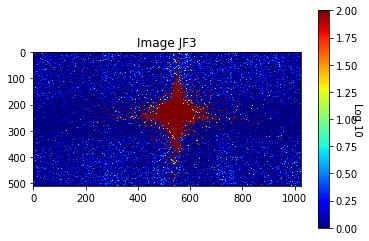

In [69]:
### Data viewing
%matplotlib inline

N_trains = len(run.train_ids)
#N_trains = 10
start = 0
for i in range(start, start+N_trains): 
    sel = run.select_trains(i)
    JF3 = sel['HED_IA1_JF500K3/DET/JNGFR03:daqOutput', 'data.adc'].xarray().squeeze()
    print("Extracted train_ID" + str(run.train_ids[i]))   
    plt.figure()
    plt.imshow(JF3.data, cmap="jet")
    #plt.imshow(np.log10(JF3), cmap="jet")
    cbar = plt.colorbar()
    plt.clim(JF3.data.min(), JF3.data.max())
    cbar.ax.set_ylabel("Intensity", rotation=270)
    #plt.ylim(390, 430)
    plt.title("Run:" + str(run_number)+ "; Train:" + str(run.train_ids[i]))
    plt.show()


# Export to CSV
#frame = pd.DataFrame(JF3.data)
#frame.to_csv("p"+propno+"/JF3.csv", float_format = "%.0f")

# Export to unformated file
f = open("p"+propno+"/JF3.dat", "w")
JF3.data.tofile(f)
f.close()

In [102]:
# Delete all files in the run directory!!!
os.chdir(run_dir)
print("Deleting files in: " + os.getcwd())
for file in os.listdir("."):    
    if os.path.isfile(file):
        os.remove(file)
        print("Delete: " + file)

Deleting files in: /home/jchal/p2575/Run302
Delete: T695489351.dat
Delete: T695489290.dat
Delete: T695489337.dat
Delete: T695489278.dat
Delete: T695489329.dat
Delete: T695489352.dat
Delete: T695489349.dat
Delete: T695489359.dat
Delete: T695489362.dat
Delete: T695489313.dat
Delete: T695489293.dat
Delete: T695489345.dat
Delete: T695489299.dat
Delete: T695489368.dat
Delete: T695489348.dat
Delete: T695489276.dat
Delete: T695489324.dat
Delete: T695489289.dat
Delete: T695489310.dat
Delete: T695489372.dat
Delete: T695489373.dat
Delete: T695489302.dat
Delete: T695489274.dat
Delete: T695489319.dat
Delete: T695489355.dat
Delete: T695489322.dat
Delete: T695489331.dat
Delete: T695489327.dat
Delete: T695489342.dat
Delete: T695489358.dat
Delete: T695489305.dat
Delete: T695489284.dat
Delete: T695489320.dat
Delete: T695489295.dat
Delete: T695489325.dat
Delete: T695489315.dat
Delete: T695489317.dat
Delete: T695489328.dat
Delete: T695489280.dat
Delete: T695489370.dat
Delete: T695489363.dat
Delete: T6954

In [14]:
#print(type(np.log10(JF3)))
# import cv2
# cv2.imwrite("p"+propno+"/JF3.csv",np.array([1,23,3]))
print(JF3.data.shape)
plt.imsave("p"+propno+"/JF3.tif",JF3.data, format="tif", cmap = cm.gray) 
#plt.imshow(np.log10(JF3.data))

(512, 1024)


In [8]:
jf=run['HED_IA1_JF500K3/DET/CONTROL']
dir(jf)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_glob_keys',
 '_has_exact_key',
 '_index_group_names',
 '_is_control',
 '_only_tids',
 'files',
 'inc_suspect_trains',
 'keys',
 'section',
 'sel_keys',
 'select_keys',
 'select_trains',
 'source',
 'train_ids',
 'union']